In [1]:
import scanpy as sc

In [2]:
from bbtnn.tnn_v3 import *

In [3]:
%%capture
adata = sc.read("/Users/lsimon/Dropbox/Platelet/BBTNN/Merge_filter.h5")
sc.pp.recipe_zheng17(adata, n_top_genes = 3000)
sc.pp.neighbors(adata, n_neighbors = 20, n_pcs = 50)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


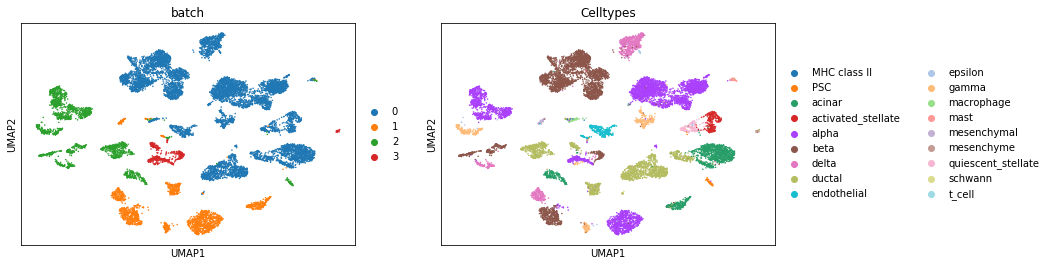

In [4]:
sc.pl.umap(adata, color = ["batch", "Celltypes"])

In [7]:
cells = []
for i in adata.obs["batch"].unique():
    tmp = np.random.choice(adata[np.where(adata.obs["batch"] == i)].obs_names, 400, replace = False)
    cells += list(tmp)

In [ ]:
%%time
model = TNN(k = 50, batch_size = 32, k_to_m_ratio = 0.5, n_epochs_without_progress = 10,
            verbose = 2, save_on_disk = False, approx = False)
#model.fit(X = adata[cells], batch_name = "batch", Y = None)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (2, 3)
5536 cells defined as MNNs
Calculating KNNs
2768 cells defined as KNNs
Re-format
Training neural network
Epoch 1/1000
260/260 - 6s - loss: 0.8967
Epoch 2/1000
260/260 - 4s - loss: 0.5403
Epoch 3/1000
260/260 - 3s - loss: 0.4680
Epoch 4/1000
260/260 - 4s - loss: 0.4179
Epoch 5/1000
260/260 - 4s - loss: 0.3738
Epoch 6/1000
260/260 - 4s - loss: 0.3606
Epoch 7/1000
260/260 - 4s - loss: 0.3197
Epoch 8/1000
260/260 - 3s - loss: 0.3062
Epoch 9/1000
260/260 - 4s - loss: 0.2798
Epoch 10/1000
260/260 - 4s - loss: 0.2590
Epoch 11/1000
260/260 - 3s - loss: 0.2490
Epoch 12/1000
260/260 - 4s - loss: 0.2404
Epoch 13/1000
260/260 - 4s - loss: 0.2398
Epoch 14/1000
260/260 - 4s - loss: 0.2391
Epoch 15/1000
260/260 - 4s - loss: 0.2258
Epoch 16/1000
260/260 - 4s - loss: 0.2208
Epoch 17/1000
260/260 - 4s - loss: 0.2092
Epoch 18

In [ ]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "Celltypes"], legend_loc = "on data")

Add supervision to loss function

In [18]:
uniq = list(adata.obs["Celltypes"].unique())
y_labels = []
for i in adata.obs["Celltypes"]:
    y_labels.append(uniq.index(i))

In [19]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 5, verbose = 2, save_on_disk = False)
model.fit(X = adata, batch_name = "batch", Y = y_labels)
embedding = model.transform(X = adata)

Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (2, 3)
5553 cells defined as MNNs
Calculating KNNs
4165 cells defined as KNNs
Re-format
Training neural network
Epoch 1/1000
304/304 - 8s - loss: 0.8521
Epoch 2/1000
304/304 - 5s - loss: 0.4523
Epoch 3/1000
304/304 - 5s - loss: 0.3637
Epoch 4/1000
304/304 - 5s - loss: 0.3200
Epoch 5/1000
304/304 - 5s - loss: 0.2714
Epoch 6/1000
304/304 - 5s - loss: 0.2686
Epoch 7/1000
304/304 - 5s - loss: 0.2472
Epoch 8/1000
304/304 - 5s - loss: 0.2367
Epoch 9/1000
304/304 - 5s - loss: 0.2254
Epoch 10/1000
304/304 - 5s - loss: 0.2093
Epoch 11/1000
304/304 - 5s - loss: 0.2133
Epoch 12/1000
304/304 - 5s - loss: 0.2029
Epoch 13/1000
304/304 - 5s - loss: 0.2050
Epoch 14/1000
304/304 - 5s - loss: 0.1981
Epoch 15/1000
304/304 - 5s - loss: 0.1953
Epoch 16/1000
304/304 - 5s - loss: 0.1858
Epoch 17/1000
304/304 - 5s - loss: 0.1856
Epoch 18

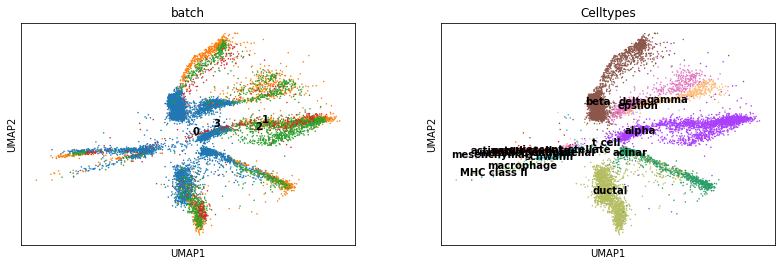

In [20]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "Celltypes"], legend_loc = "on data")

In [ ]:
mask = np.random.choice(range(len(Y_train)), size=len(Y_train) // 2, replace=False)
Y_train_masked = np.array(Y_train, dtype=np.int8) # Can't use uint to represent
Y_train_masked[mask] = -1